## WEATHER FORECASTING USING LSTM

 Contribution: Siddhesh Shaji(CWID:10458882)

## Importing all the necessary libraries


In [ ]:
# Note that this entire code has been run on datasets for three cities(Mumbai, Dallas and NYC)
# But since it is repetitive, we have kept the results from Dallas only
# But the models that were trained on all three datatests can be found in the submitted project folder

In [1]:
!pip install pmdarima
import json
import pickle
import joblib
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import array
from requests import get
from tensorflow import keras
from fbprophet import Prophet
import matplotlib.pyplot as plt
#from selenium import webdriver
from pmdarima import auto_arima
from keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import load_model
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from sklearn.preprocessing import StandardScaler
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from statsmodels.tsa.seasonal import seasonal_decompose
from fbprophet.serialize import model_to_json, model_from_json


     |████████████████████████████████| 1.5 MB 4.4 MB/s eta 0:00:01


## Using selenium to fetch data from www.wunderground.com for the cities of nyc, mumbai and dallas

In [2]:
"""appended_data = pd.DataFrame()

for i in range(2018,2022):      # From year 2018 to 2021
    for j in range(1,13):       # For all the months
        for k in range(1,32):   # For all the days

            #url = 'https://www.wunderground.com/history/daily/in/mumbai/VABB/date/{}-{}-{}'.format(i,j,k)  #30
            #url = 'https://www.wunderground.com/history/daily/KLGA/date/{}-{}-{}'.format(i,j,k)  #51
            
            url = 'https://www.wunderground.com/history/daily/us/tx/dallas/KDAL/date/{}-{}-{}'.format(i,j,k)  #53  
            driver = webdriver.Chrome(executable_path='/Users/siddhesh/Desktop/Study/chromedriver')
            driver.get(url)
            driver.implicitly_wait(10)    # Wait until the page loads up

            table = driver.find_element_by_class_name('mat-table.cdk-table.mat-sort.ng-star-inserted')    # find the table of interest by its class name
            table = pd.read_html(table.get_attribute('outerHTML')) 

            driver.quit()
            
            # some feature engineering

            table[0].dropna(inplace=True)
            table[0] = table[0][table[0].Time.str.contains('53')]

            if (j<10)and(k<10):
                table[0]['Time'] = '{}0{}0{}'.format(i,j,k) + " "+ table[0]['Time'].astype(str)
                appended_data = appended_data.append(table[0])

            elif (j<10) and (k>=10):
                table[0]['Time'] = '{}0{}{}'.format(i,j,k) + " "+ table[0]['Time'].astype(str)
                appended_data = appended_data.append(table[0])

            elif (j>=10) and (k<10):
                table[0]['Time'] = '{}{}0{}'.format(i,j,k) + " "+ table[0]['Time'].astype(str)
                appended_data = appended_data.append(table[0])
            else:
                table[0]['Time'] = '{}{}{}'.format(i,j,k) + " "+ table[0]['Time'].astype(str)
                appended_data = appended_data.append(table[0])

"""

'appended_data = pd.DataFrame()\n\nfor i in range(2018,2022):      # From year 2018 to 2021\n    for j in range(1,13):       # For all the months\n        for k in range(1,32):   # For all the days\n\n            #url = \'https://www.wunderground.com/history/daily/in/mumbai/VABB/date/{}-{}-{}\'.format(i,j,k)  #30\n            #url = \'https://www.wunderground.com/history/daily/KLGA/date/{}-{}-{}\'.format(i,j,k)  #51\n            \n            url = \'https://www.wunderground.com/history/daily/us/tx/dallas/KDAL/date/{}-{}-{}\'.format(i,j,k)  #53  \n            driver = webdriver.Chrome(executable_path=\'/Users/siddhesh/Desktop/Study/chromedriver\')\n            driver.get(url)\n            driver.implicitly_wait(10)    # Wait until the page loads up\n\n            table = driver.find_element_by_class_name(\'mat-table.cdk-table.mat-sort.ng-star-inserted\')    # find the table of interest by its class name\n            table = pd.read_html(table.get_attribute(\'outerHTML\')) \n\n         

## Save the data in csv format

In [3]:
# appended_data['Time'] =  pd.to_datetime(appended_data['Time'], infer_datetime_format=True)
# appended_data.to_csv("tx_weather_full.csv")  

In [4]:
# Reading the csv
df=pd.read_csv('../input/dallasweather/tx_weather_full.csv',parse_dates = True)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28143 entries, 0 to 28142
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Time         28143 non-null  object 
 1   Temperature  28143 non-null  int64  
 2   Dew Point    28143 non-null  int64  
 3   Humidity     28143 non-null  int64  
 4   Wind         28143 non-null  object 
 5   Wind Speed   28143 non-null  int64  
 6   Wind Gust    28143 non-null  int64  
 7   Pressure     28143 non-null  float64
 8   Precip.      28143 non-null  float64
 9   Condition    28143 non-null  object 
dtypes: float64(2), int64(5), object(3)
memory usage: 2.1+ MB


In [6]:
df.describe()

,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,Precip.
count,28143.000000,28143.000000,28143.000000,28143.000000,28143.000000,28143.000000,28143.000000
mean,67.368546,52.106350,61.423729,9.042675,5.119070,29.496514,0.004886
std,17.293868,16.219922,19.087981,5.017798,10.068432,0.531025,0.048639
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,54.000000,38.000000,47.000000,6.000000,0.000000,29.380000,0.000000
50%,68.000000,55.000000,62.000000,9.000000,0.000000,29.480000,0.000000
75%,81.000000,67.000000,76.000000,13.000000,0.000000,29.610000,0.000000
max,111.000000,78.000000,100.000000,33.000000,63.000000,30.310000,2.300000


<AxesSubplot:>

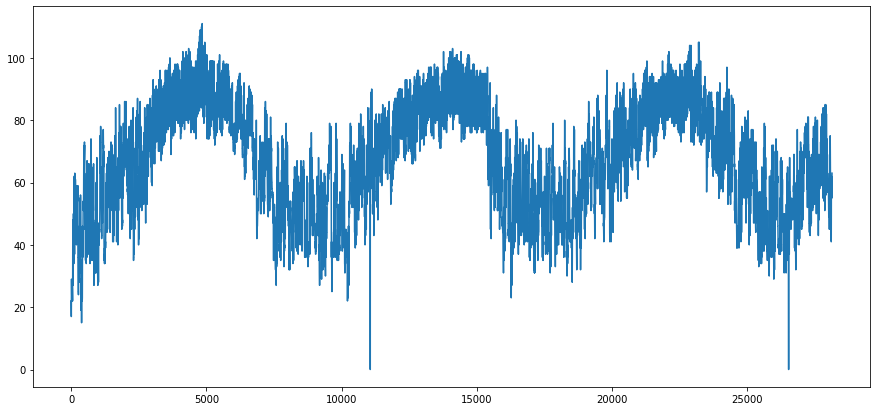

In [7]:
# Plotting the temperature column
df['Temperature'].plot(figsize=(15,7))

<AxesSubplot:>

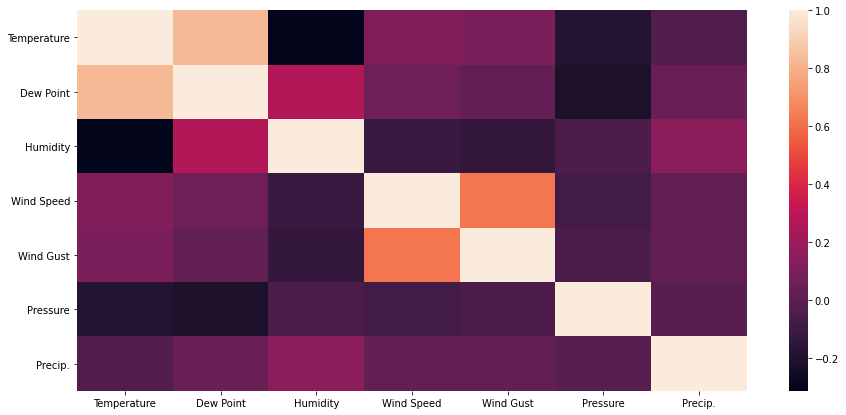

In [8]:
# plot the heatmap

%matplotlib inline
fig, ax = plt.subplots(figsize=(15,7)) 

# calculate the correlation matrix
corr = df.corr()

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns, ax=ax)

In [9]:
# Printing the correaltion matrix

corr

# It can be seen that the features 'dew point', 'humidity', 'wind speed', 'pressure'
# have good correlation with temperature

,Temperature,Dew Point,Humidity,Wind Speed,Wind Gust,Pressure,Precip.
Temperature,1.000000,0.826035,-0.313768,0.115387,0.096170,-0.185563,-0.036815
Dew Point,0.826035,1.000000,0.262557,0.050604,0.018657,-0.213251,0.036320
Humidity,-0.313768,0.262557,1.000000,-0.116161,-0.134982,-0.050365,0.150025
Wind Speed,0.115387,0.050604,-0.116161,1.000000,0.620483,-0.078751,0.016559
Wind Gust,0.096170,0.018657,-0.134982,0.620483,1.000000,-0.049461,0.022931
Pressure,-0.185563,-0.213251,-0.050365,-0.078751,-0.049461,1.000000,-0.013410
Precip.,-0.036815,0.036320,0.150025,0.016559,0.022931,-0.013410,1.000000


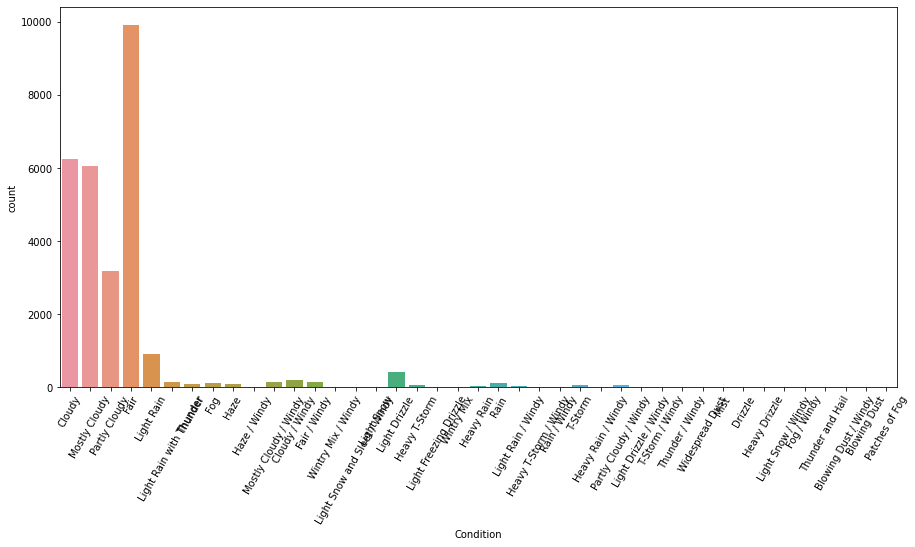

In [10]:
# Distribution of weather condition types in dallas, texas

fig, ax = plt.subplots(figsize=(15,7)) 
plt.xticks(rotation=60)
ax = sns.countplot(x="Condition", data=df)

'   N = North (349 - 011 degrees)\n    NNE = North-Northeast (012-033 degrees)\n    NE = Northeast (034-056 degrees)\n    ENE = East-Northeast (057-078 degrees)\n    E = East (079-101 degrees)\n    ESE = East-Southeast (102-123 degrees)\n    SE = Southeast (124-146 degrees)\n    SSE = South-Southeast (147-168 degrees)\n    S = South (169-191 degrees)\n    SSW = South-Southwest (192-213 degrees)\n    SW = Southwest (214-236 degrees)\n    WSW = West-Southwest (237-258 degrees)\n    W = West (259-281 degrees)\n    WNW = West-Northwest (282-303 degrees)\n    NW = Northwest (304-326 degrees)\n    NNW = North-Northwest (327-348 degrees)\n    VAR = Variable wind direction\n    CLM = Calm winds (speed = 0 knots)\n    ALL = All direction categories combined\n'

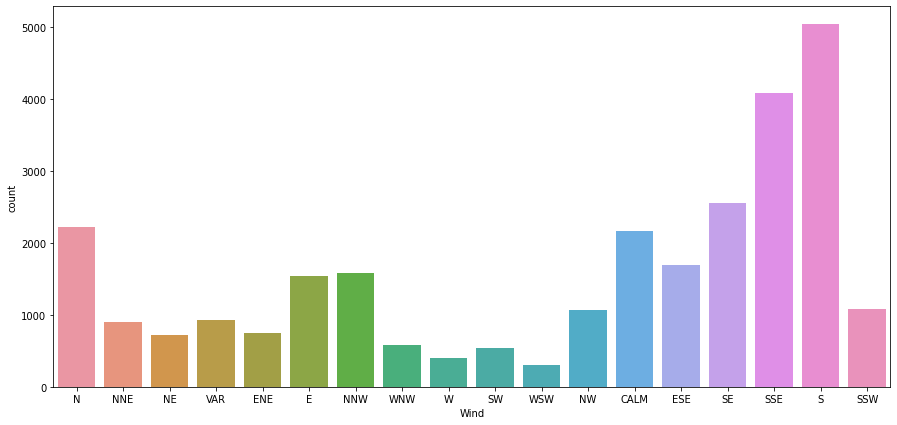

In [11]:
# Distribution of wind types in dallas, texas

fig, ax = plt.subplots(figsize=(15,7)) 

ax = sns.countplot(x="Wind", data=df)


"""   N = North (349 - 011 degrees)
    NNE = North-Northeast (012-033 degrees)
    NE = Northeast (034-056 degrees)
    ENE = East-Northeast (057-078 degrees)
    E = East (079-101 degrees)
    ESE = East-Southeast (102-123 degrees)
    SE = Southeast (124-146 degrees)
    SSE = South-Southeast (147-168 degrees)
    S = South (169-191 degrees)
    SSW = South-Southwest (192-213 degrees)
    SW = Southwest (214-236 degrees)
    WSW = West-Southwest (237-258 degrees)
    W = West (259-281 degrees)
    WNW = West-Northwest (282-303 degrees)
    NW = Northwest (304-326 degrees)
    NNW = North-Northwest (327-348 degrees)
    VAR = Variable wind direction
    CLM = Calm winds (speed = 0 knots)
    ALL = All direction categories combined
"""

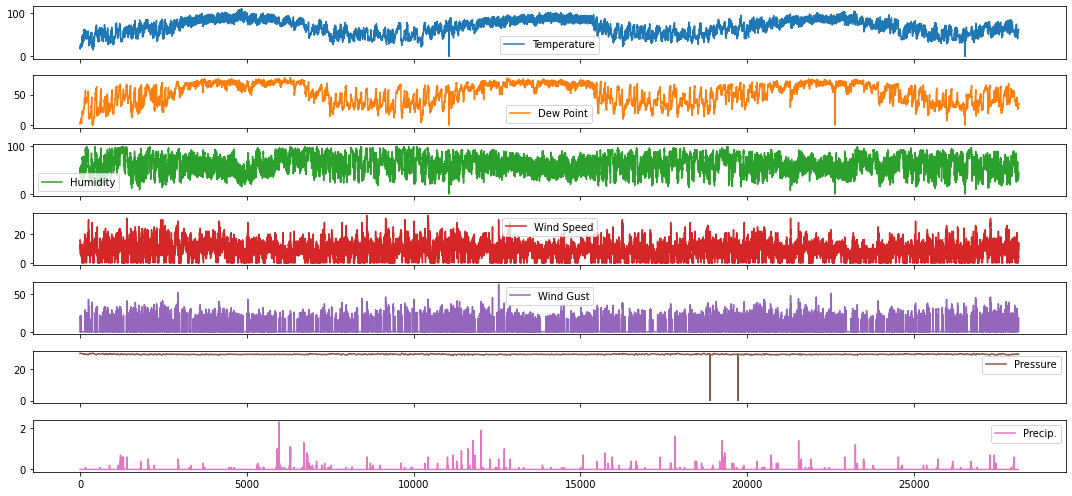

In [12]:
df.plot(subplots=True,figsize=(15,7))
plt.tight_layout()
plt.show()

# # **ARIMA**

<AxesSubplot:>

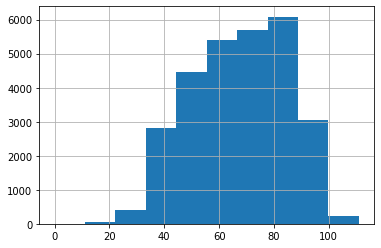

In [13]:
temp = df['Temperature']
temp.hist()

In [14]:
# Augmented Dickey-Fuller test for stationary data check

adftest = adfuller(df['Temperature'])

print("ADF : ",adftestadftest[0])
print("P-Value : ", adftest[1])
print("Num Of Lags : ", adftest[2])
print("Num Of Observations Used For ADF Regression:", adftest[3])
print("Critical Values :")
for key, value in adftest[4].items():
    print('\t%s: %.3f' % (key, value))
    

# Null Hypothesis (H0): Data is not stationary
# Alternate Hypothesis (H1): It is stationary


# Running the example prints the test statistic value of -7.45. 
# The more negative this statistic, the more likely we are to reject the null hypothesis 
# Therefore(we have a stationary dataset). It does not have time-dependent structure.

# As part of the output, we get a look-up table to help determine the ADF statistic. 
# We can see that our statistic value of -7.455 is less than the value of -3.431 at 1%.

# This suggests that we can reject the null hypothesis with a significance level of 
# less than 1% (i.e. a low probability that the result is a statistical fluke).

ADF :  -7.459458789027069
P-Value :  5.402022309281731e-11
Num Of Lags :  49
Num Of Observations Used For ADF Regression: 28093
Critical Values :
	1%: -3.431
	5%: -2.862
	10%: -2.567


In [15]:
# Running the auto-arima
auto_fit = auto_arima(df['Temperature'], seasonal=True, trace=True, suppress_warnings=True)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=113292.205, Time=53.89 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=124885.185, Time=0.82 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=119234.597, Time=2.31 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=121296.873, Time=3.99 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=124883.198, Time=0.41 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=117294.530, Time=7.48 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=117445.661, Time=9.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=112962.670, Time=58.96 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=117409.583, Time=15.09 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=113259.560, Time=85.50 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=113294.435, Time=51.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=115232.245, Time=71.33 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=114846.309, Time=32.61 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=87.01 sec
 ARI

In [16]:
auto_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                28143
Model:               SARIMAX(3, 1, 2)   Log Likelihood              -56474.326
Date:                Thu, 20 May 2021   AIC                         112960.652
Time:                        02:56:33   BIC                         113010.123
Sample:                             0   HQIC                        112976.574
                              - 28143                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          2.0525      0.003    794.963      0.000       2.047       2.058
ar.L2         -1.2356      0.005   -258.948      0.000      -1.245      -1.226
ar.L3          0.1230      0.002     51.781      0.000       0.118       0.128
ma.L1         -1.8924      0.002   -939.853      0.000      -1.896      -1.888
ma.L2          0.9569      0.002    476.644      0.000       0.953       0.961
sigma2         3.2398      0.004    734.660      0.000       3.231       3.248
===================================================================================
Ljung-Box (L1) (Q):                   4.55   Jarque-Bera (JB):          87227704.99
Prob(Q):                              0.03   Prob(JB):                         0.00
Heteroskedasticity (H):               1.17   Skew:                             0.88
Prob(H) (two-sided):                  0.00   Kurtosis:                       275.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# train test split for testing the model

train=df['Temperature'].iloc[:-120]
test=df['Temperature'].iloc[-120:]

(28143, 10)
(28023,) (120,)


# Fit the training data


In [18]:
model = auto_fit.fit(train)

# Forecast 120 hours (5 days) in the future


In [19]:
forecast = model.predict(n_periods = 120, return_conf_int = True)

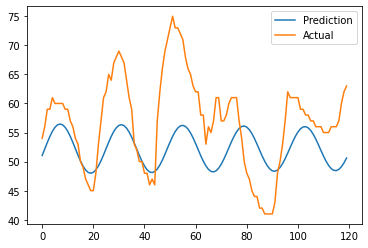

In [20]:
plt.plot(np.array(forecast[0]), label='Prediction')
plt.plot(np.array(test), label='Actual')
plt.legend()

# Multivariate LSTM

In [41]:
df=pd.read_csv('../input/dallasweather/tx_weather_full.csv')
train_dates =  pd.to_datetime(df['Time'], infer_datetime_format=True)

# Taking only the important columns we got to know from the correaltion matrix
df1 = df[['Temperature','Dew Point','Humidity','Wind Speed','Pressure']]

df_train = df1.astype(float)

In [42]:
# LSTM uses sigmoid and tanh that are sensitive to magnitude so values need to be normalized

scaler = StandardScaler()
scaler = scaler.fit(df_train)
df_train = scaler.transform(df_train)

In [44]:
# As required for LSTM networks, we require to reshape an input data into 
# n_samples * timesteps * n_features

train_x = []
train_y = []

n_future = 1   # Number of days we want to predict into the future
n_past = 30     # Number of past days we want to use to predict the future

for i in range(n_past, len(df_train) - n_future +1):
    train_x.append(df_train[i - n_past:i, 0:df_train.shape[1]])
    train_y.append(df_train[i + n_future - 1:i + n_future, 0])

train_x, train_y = np.array(train_x), np.array(train_y)

print('trainX shape == {}.'.format(train_x.shape))
print('trainY shape == {}.'.format(train_y.shape))

trainX shape == (28113, 30, 5).
trainY shape == (28113, 1).


# Initialing the model design


In [45]:
# two hidden layers with 64 and 32 nodes each, activation functions relu for both the layers, a dropout of 0.4
# optimizer used:Adam and loss to be optimized: mse 
# trained for 10 epochs on a batch size of 64 with a validation split of 20%

model = Sequential()
model.add(LSTM(64, activation='relu', input_shape=(train_x.shape[1], train_x.shape[2]), return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=False))
model.add(Dropout(0.4))
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam', loss='mse')
model.summary()


# fitting the model
history = model.fit(train_x, train_y, epochs=10, batch_size=64, validation_split=0.2, verbose=1)


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 30, 64)            17920     
_________________________________________________________________
lstm_3 (LSTM)                (None, 32)                12416     
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 30,369
Trainable params: 30,369
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
352/352 [==============================] - 14s 36ms/step - loss: 0.3226 - val_loss: 0.0362
Epoch 2/10
352/352 [==============================] - 12s 35ms/step - loss: 0.0858 - val_loss: 0.0337
Epoch 3/10
352/352 [========================

# Visualizing the training and validation losses


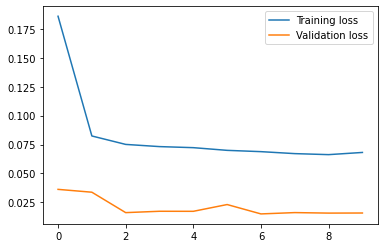

In [46]:
plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.legend()

# Forecasting the next 120 hours(5 days)


In [47]:
#Start with the last day in training date and predict future

n_future = 120  #Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = pd.date_range(list(train_dates)[-1], periods=n_future, freq='1H').tolist()
forecast = model.predict(train_x[-n_future:]) #forecast 

In [48]:
#Perform inverse transformation to rescale back to original range
#Since we used 5 variables for transform, the inverse expects same dimensions
#Therefore, let us copy our values 5 times and discard them after inverse transform

forecast_copies = np.repeat(forecast, df_train.shape[1], axis=-1)
y_pred_future = scaler.inverse_transform(forecast_copies)[:,0]
y_pred_future

array([50.902424, 55.793545, 57.76893 , 60.34103 , 60.176098, 61.05132 ,
       60.057663, 59.4106  , 59.20702 , 58.977497, 58.175144, 57.944458,
       56.514587, 55.45078 , 53.8878  , 52.96067 , 50.371048, 49.40935 ,
       47.71108 , 47.005314, 46.76922 , 46.858448, 50.622322, 57.099934,
       61.179592, 64.14432 , 64.069405, 66.47264 , 64.950134, 66.73445 ,
       67.305016, 67.654076, 66.57197 , 65.066475, 62.670235, 59.76212 ,
       57.45598 , 52.633488, 51.355072, 49.921448, 50.473392, 48.82084 ,
       49.605927, 47.750843, 49.49535 , 49.222706, 65.25467 , 68.61393 ,
       69.8112  , 71.63876 , 72.62669 , 73.46358 , 74.41584 , 72.007256,
       70.7951  , 69.42648 , 67.880806, 65.856575, 64.06108 , 62.926064,
       61.62979 , 60.788227, 60.729256, 57.847424, 57.790977, 53.474873,
       56.87202 , 56.48787 , 58.942806, 64.115425, 63.193993, 58.99717 ,
       57.62068 , 59.04373 , 61.264706, 62.212482, 61.66476 , 61.079384,
       57.430904, 54.138348, 49.90315 , 47.591557, 

In [49]:
# Convert timestamp to date

forecast_dates = []
for i in forecast_period_dates:
    forecast_dates.append(i.date())
    
df_forecast = pd.DataFrame({'Time':np.array(forecast_dates), 'Temperature':y_pred_future})
df_forecast['Time']=pd.to_datetime(df_forecast['Time'])


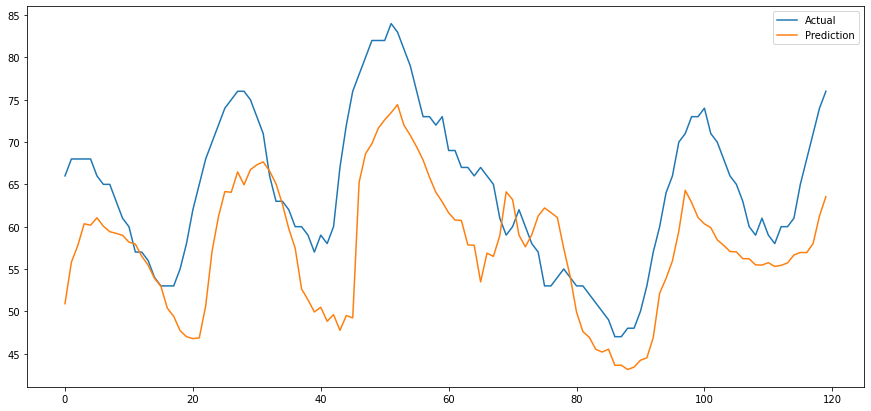

In [50]:
# indexing the same period from 2019 in order to compare the results

actual = df[2670:2790]['Temperature'] #

%matplotlib inline
fig, ax = plt.subplots(figsize=(15,7)) 

plt.plot(np.array(actual), label='Actual')
plt.plot(np.array(df_forecast['Temperature']), label='Prediction')
plt.legend()

# FBProphet

In [51]:
# Getting the data in the suitable form for prophet

df = pd.read_csv('../input/dallasweather/tx_weather_full.csv')
df = df[['Time','Temperature']]
df.columns = ['ds','y']
df['ds'] = pd.to_datetime(df['ds'])
df.head()

,ds,y
0,2018-01-01 01:53:00,22
1,2018-01-01 02:53:00,21
2,2018-01-01 03:53:00,20
3,2018-01-01 04:53:00,20
4,2018-01-01 05:53:00,19


Steps
* Initialize Model :: Prophet()
* Set columns as ds,y
* Fit dataset :: Prophet().fit()
* Create Dates To predict :: Prophet().make_future_dataframe(periods=168)
* Predict :: Prophet().predict(future_dates) 
* Plot :: Prophet().plot(predictions)

# # Fitting the model 


In [52]:
model=Prophet(yearly_seasonality = True)
model.fit(df)

In [53]:
# Making predictions for a year in advance 

future_dates=model.make_future_dataframe(periods=8760,freq='H',include_history = False)
prediction=model.predict(future_dates)
prediction.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2021-04-22 14:53:00,67.073824,63.329318,83.326956,67.073824,67.073824,6.758081,6.758081,6.758081,6.945810,...,0.282479,0.282479,0.282479,-0.470208,-0.470208,-0.470208,0.0,0.0,0.0,73.831905
1,2021-04-22 15:53:00,67.073555,63.677872,84.859329,67.073555,67.073555,7.554686,7.554686,7.554686,7.702595,...,0.303042,0.303042,0.303042,-0.450950,-0.450950,-0.450950,0.0,0.0,0.0,74.628241
2,2021-04-22 16:53:00,67.073286,64.326132,85.595910,67.073286,67.073286,7.653036,7.653036,7.653036,7.763625,...,0.321097,0.321097,0.321097,-0.431686,-0.431686,-0.431686,0.0,0.0,0.0,74.726322
3,2021-04-22 17:53:00,67.073017,63.883233,84.332461,67.073017,67.073017,6.896709,6.896709,6.896709,6.972666,...,0.336456,0.336456,0.336456,-0.412413,-0.412413,-0.412413,0.0,0.0,0.0,73.969725
4,2021-04-22 18:53:00,67.072748,61.725143,82.649954,67.072748,67.072748,5.412790,5.412790,5.412790,5.456962,...,0.348961,0.348961,0.348961,-0.393134,-0.393134,-0.393134,0.0,0.0,0.0,72.485537


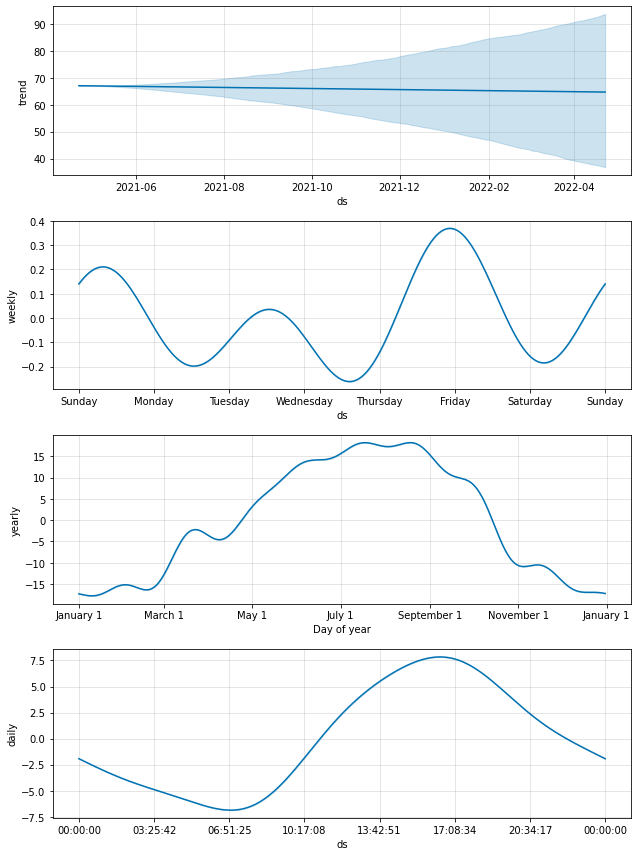

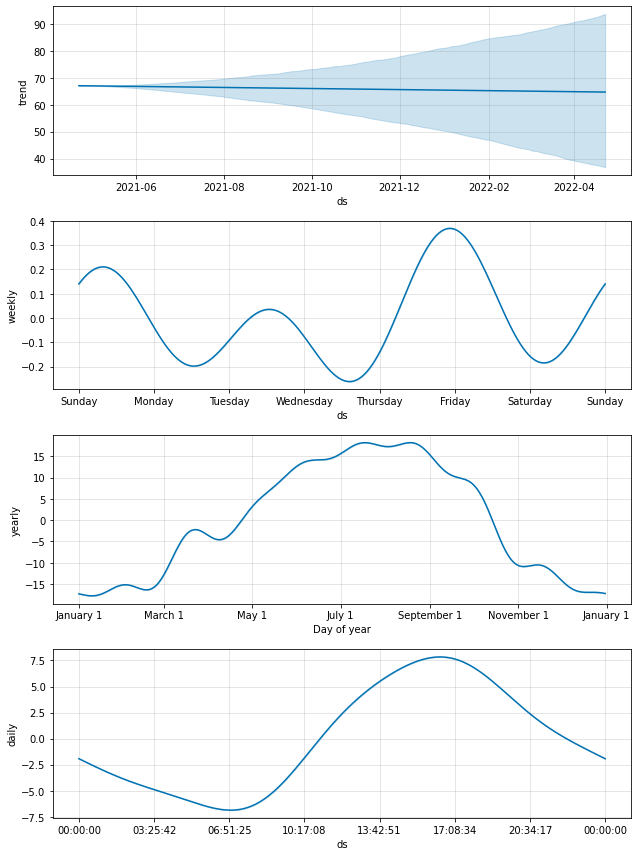

In [54]:
# Plotting the model components 

model.plot_components(prediction)

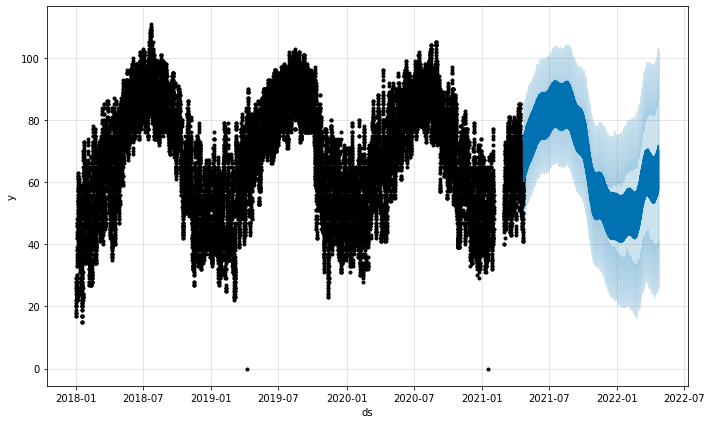

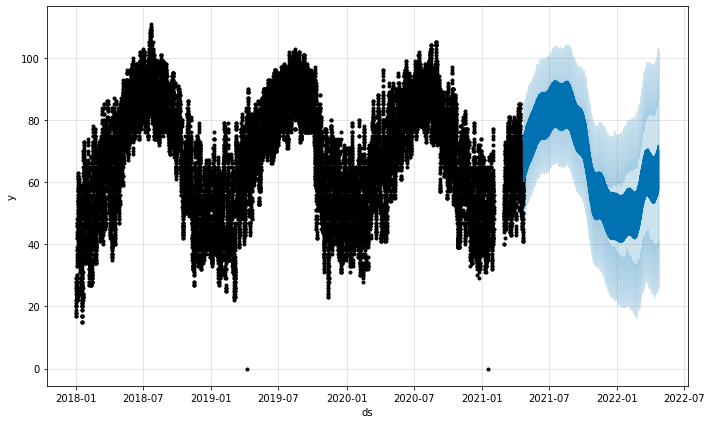

In [55]:
# Plotting the prediction

model.plot(prediction)

## Demo for dates for the whole year of 2019


In [56]:
actual = df[(df['ds'] > '2019-01-01') & (df['ds'] < '2020-01-01')]['y']

forecast_period_dates = pd.date_range(start='1/1/2019', end='1/01/2020', freq='1H')
forecast_period_dates = pd.DataFrame(forecast_period_dates)
forecast_period_dates.columns = ['ds']

prediction = model.predict(forecast_period_dates)
prediction_actual = prediction['yhat']
prediction_low = prediction['yhat_lower']
prediction_high = prediction['yhat_upper']

## Plotting the results vs actual plots

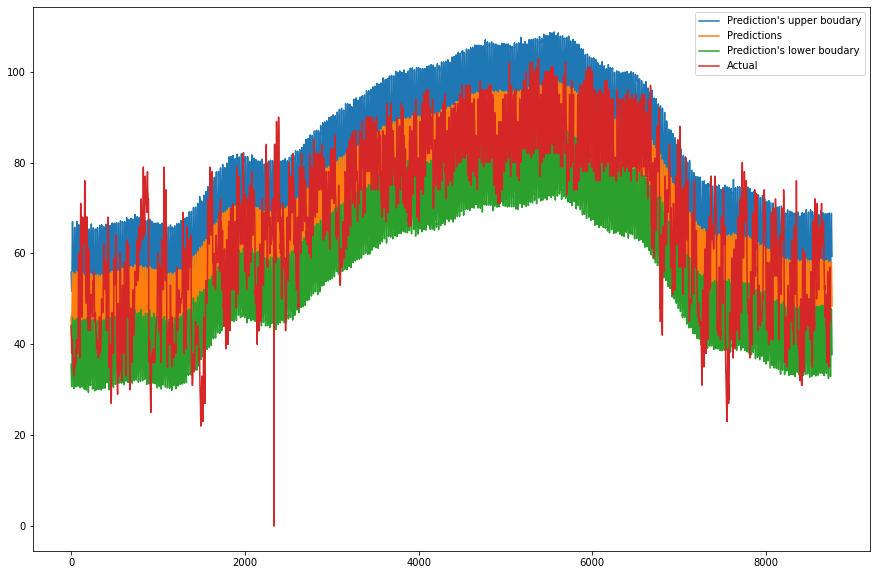

In [57]:
%matplotlib inline
fig, ax = plt.subplots(figsize=(15,10)) 

plt.plot(np.array(prediction_high), label="Prediction's upper boudary")

plt.plot(np.array(prediction_actual), label='Predictions')

plt.plot(np.array(prediction_low), label="Prediction's lower boudary")

plt.plot(np.array(actual), label='Actual')

plt.legend()

## Saving the model in json or pkl format

In [58]:
#with open('tx_model.pkl', 'wb') as fout:
#    pickle.dump(model, fout)
    
#joblib.dump(model, 'tx1_model.pkl')

#with open('tx1_model.json', 'w') as fout:
#    json.dump(model_to_json(model), fout)  # Save model
    
#with open('tx1_model.json', 'r') as fin:
#    model = model_from_json(json.load(fin))  # Load model

## Cross validation on the dataset


In [59]:
df_cv_results = cross_validation(model, horizon = '2190 hours') # initial='17520 hours', period='1 hours', horizon = '1 hours')
df_cv_results 

  0%|          | 0/17 [00:00<?, ?it/s]

,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2019-01-22 08:53:00,41.904216,31.717221,51.155154,58,2019-01-22 07:53:00
1,2019-01-22 09:53:00,44.020805,33.419836,54.387416,58,2019-01-22 07:53:00
2,2019-01-22 10:53:00,46.478346,36.711276,57.248973,59,2019-01-22 07:53:00
3,2019-01-22 11:53:00,48.798170,38.099063,58.611878,62,2019-01-22 07:53:00
4,2019-01-22 12:53:00,50.742856,41.039465,60.891036,64,2019-01-22 07:53:00


In [60]:
df_perf_metrics = performance_metrics(df_cv)
df_perf_metrics

# RMSE is coming out to be ~8.5 for 8 days horizon and it is increasing as the horizon increases

,horizon,mse,rmse,mae,mdape,coverage
0,8 days 19:00:00,72.093189,8.490771,6.488342,0.074117,0.797884
1,8 days 20:00:00,72.301788,8.503046,6.499077,0.074342,0.797866
2,8 days 21:00:00,72.501984,8.514810,6.509242,0.074342,0.797554
3,8 days 22:00:00,72.564027,8.518452,6.514507,0.074433,0.797515
4,8 days 23:00:00,72.621529,8.521827,6.518881,0.074503,0.797536
...,...,...,...,...,...,...
1975,91 days 02:00:00,348.084266,18.657017,13.603522,0.136161,0.624860
1976,91 days 03:00:00,348.294786,18.662658,13.598459,0.136161,0.625263
1977,91 days 04:00:00,348.383376,18.665031,13.590996,0.135849,0.625772
1978,91 days 05:00:00,348.365940,18.664564,13.580887,0.135787,0.626597


## Plotting the rmse

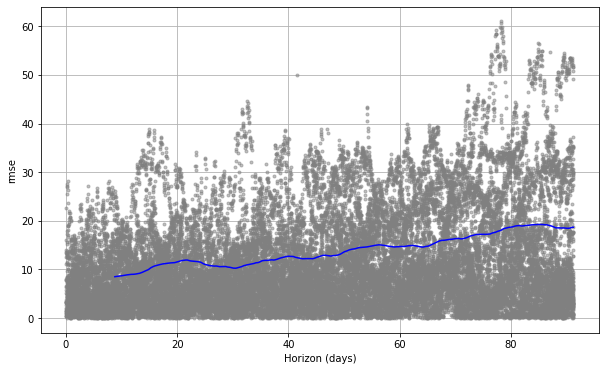

In [61]:
fig = plot_cross_validation_metric(df_cv, metric='rmse')

# RMSE is coming out to be ~8.5 for 8 days horizon and it is increasing as the horizon increases

## Univariate LSTM

Contribution of the code that follows from here: Manav Sharma

In [ ]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pydotplus
import os
import warnings
warnings.filterwarnings("ignore")
df = pd.read_csv(r"C:\Users\Manav\OneDrive\Desktop\Stevens online classes\machine learning\group project\tx_weather_full.csv")

In [ ]:
df['Time']

In [ ]:
df['Condition'].value_counts()


In [ ]:
plt.figure(figsize=(15,10))
df['Condition'].value_counts().head(20).plot(kind='bar')

plt.title('20 most common weather conditions in Texas')
plt.show()

In [ ]:
plt.figure(figsize=(15, 10))
plt.title("Common wind direction in Texas")
df['Wind'].value_counts().plot(kind="bar")
plt.plot()


In [ ]:
plt.figure(figsize=(15, 10))
sns.distplot(df['Temperature'],bins=[i for i in range(0,100,5)], kde=False)
plt.title("Distribution of Temperatures")
plt.grid()
plt.show()


In [ ]:
df['Time'] = pd.to_datetime(df['Time'])


In [ ]:
# to extract year part from the date
def get_year(x):
    return x[0:4]


# to extract month part from the date
def get_month(x):
    return x[5:7]

df['year'] = df['Time'].apply(lambda x: get_year(str(x)))
df['month'] = df['Time'].apply(lambda x: get_month(str(x)))


In [ ]:
temp_year = pd.crosstab(df['year'], df['month'], values=df['Temperature'], aggfunc='mean')

plt.figure(figsize=(15, 10))
sns.heatmap(temp_year, cmap='coolwarm', annot=True)
plt.title("Average Tempearture in Texas from 2018 to 2021")
plt.show()

humidity_year = pd.crosstab(df['year'], df['month'], values=df['Humidity'], aggfunc='mean')

plt.figure(figsize=(15, 10))
sns.heatmap(humidity_year, cmap='coolwarm', annot=True)
plt.title("Average Humidity in Texas from 2018 to 2021")
plt.show()


In [ ]:
# Time series forecasting

data = pd.DataFrame(list(df['Temperature']), index=df['Time'], columns=['temp'])

plt.figure(figsize=(25, 7))
plt.plot(data, linewidth=.5)
plt.grid()
plt.title("Time Series (Years vs Temp.)")
plt.show()


In [ ]:
# Scaling data to remove outliers
from sklearn.preprocessing import MinMaxScaler
scalar = MinMaxScaler(feature_range=(-1,1))
data_scaled = scalar.fit_transform(data)

data_scaled.shape

In [ ]:
timestep = 30
X= []
Y=[]
for i in range(len(data_scaled)- (timestep)):
    X.append(data_scaled[i:i+timestep])
    Y.append(data_scaled[i+timestep])

X=np.asanyarray(X)
Y=np.asanyarray(Y)

#splitting data
k = 19700
Xtrain = X[:k,:,:]
Xtest = X[k:,:,:]    
Ytrain = Y[:k]    
Ytest= Y[k:]

Xtest.shape


In [ ]:
from tensorflow.keras.layers import Dense,RepeatVector, LSTM, Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPooling1D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, Dropout


In [ ]:
model = Sequential()
model.add(Conv1D(filters=256, kernel_size=2, activation='relu', input_shape=(30,1)))
model.add(Conv1D(filters=128, kernel_size=2, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(RepeatVector(30))
model.add(LSTM(units=100, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=100, return_sequences=True))
model.add(LSTM(units=100, return_sequences=True))
model.add(Bidirectional(LSTM(128, activation='relu')))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(loss='mse', optimizer='adam')
history = model.fit(Xtrain,Ytrain,epochs=150, verbose=1 )


In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png')

predict = model.predict(Xtest)
predict = scalar.inverse_transform(predict)
Ytesting = scalar.inverse_transform(Ytest)

In [ ]:
plt.figure(figsize=(30,10))
plt.plot(Ytesting , 'b', linewidth=1)
plt.plot(predict,'r' , linewidth=1)
plt.legend(('Test', 'Predict'),loc='upper right')
plt.show()

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(Ytesting,predict)

results = model.evaluate(Xtest, Ytest, batch_size=128)
print("test loss, test acc:", results)


In [ ]:
# Start with the last day in training date and predict future

n_future = 120  # Redefining n_future to extend prediction dates beyond original n_future dates...
forecast_period_dates = pd.date_range(list(df['Time'])[-1], periods=n_future, freq='1H').tolist()
forecast = model.predict(Xtrain[-n_future:]) #forecast

forecast = scalar.inverse_transform(forecast)

plt.figure(figsize=(25, 7))
plt.plot(forecast, linewidth=.5)
plt.grid()
plt.title("Forecast for the next 5 days")
plt.show()